In [11]:
!pip install selenium

In [ ]:
#please specify the path where you want to save: 
#rawdatafile
rawdatapath="r'C:\Users\evrijghem\Documents\Python\Individual\rawdata.csv'"
#cleandatafile(finaldatatable)
cleandatapath="r'C:\Users\evrijghem\Documents\Python\Individual\finaltable.csv'"

In [28]:
from selenium.webdriver import Chrome
import pandas as pd
import time
from selenium.webdriver.common.keys import Keys
#import java.util.concurrent.TimeUnit;

webdriver = "C:/Users/evrijghem/Documents/Python/Individual/chromedriver.exe"

driver = Chrome(webdriver)
#driver.manage().timeouts().implicitlyWait(10, TimeUnit.SECONDS);
url = "https://www.bienici.com/recherche/achat/la-madeleine-59110,marcq-en-baroeul-59700" 
driver.get(url)
time.sleep(20)

python_button = driver.find_elements_by_xpath('//*[@id="searchSideHeader"]/div/div[2]/div/div/div/div[2]')[0]
python_button.click()

quotes = driver.find_elements_by_class_name("sideListItemSecondBlock")
quote = quotes[2]

Title = quote.find_element_by_class_name('descriptionTitle')
try:
    Title.click()
except :
    pass
    
length = driver.find_element_by_class_name('totalDetailedSheets').text
length=int(length)

In [ ]:
datalist = []
for x in range(1,length+1):
    time.sleep(10)
    try:
        ads = driver.find_element_by_xpath('//*[@id="loader"]/div[6]/div/div/div/div/button')
        ads.send_keys(Keys.RETURN)
    except:
        pass
    time.sleep(7)
    
    label = driver.find_element_by_class_name('realEstateAdsMainInfo').text
    address= driver.find_element_by_class_name('fullAddress').text
    
    print(x)
    print(str(label))
    print(str(address))
    
    
    #following are put in try loops because sometimes they are not there
    try: 
        energy1 = driver.find_element_by_xpath('/html/body/div[1]/section/div/div[3]/section[4]/div[2]/div[1]/div[1]/span').text
        #energy1 = Energy Performance indicator
       
    except:
        energy1 = "NA"
    print(str(energy1))
    try:
        energy2 = driver.find_element_by_xpath('/html/body/div[1]/section/div/div[3]/section[4]/div[2]/div[2]/div[1]/span').text
        # energy2 = Greenhouse gas emissions (both are yearly estimation)
    except:
        energy2 = "NA"
    print(str(energy2))
    try:
        energy1label = driver.find_element_by_xpath('/html/body/div[1]/section/div/div[3]/section[4]/div[2]/div[1]/div[1]/span[2]').text
    except:
        energy1label ="NA"
    print(energy1label)
    try: 
        energy2label = driver.find_element_by_xpath('/html/body/div[1]/section/div/div[3]/section[4]/div[2]/div[2]/div[1]/span[2]').text
    except:
        energy2label ="NA"
    print(energy2label)
    time.sleep(4)
    try:
        pricesquare = driver.find_element_by_xpath('/html/body/div[1]/section/div/div[3]/div[1]/div[1]/div[2]/div[1]/div/div/div/span[2]').text
        print(pricesquare)
    except:
        pricesquare = "NA" 
    
    specifics = driver.find_elements_by_class_name('labelInfo')
    informationlist=[]
#creating a loop to be able to scrape this data (they all have the same html adress)
    numberappends =[]
    for i in specifics:
        x = i.text
        informationlist.append(x)
    
    button= driver.find_element_by_id('selectNextDetailedSheet')
    time.sleep(2)
    try:
        button.click()
    except :
        pass
    
 #putting all the information into a usable dataframe   
        
    info=((label,address,energy1,energy1label,energy2,energy2label,pricesquare,informationlist))
    datalist.append(info)
    dataframe = pd.DataFrame(datalist,columns=['label','adress','energy1','energy1label','energy2','energy2label','pricesquare','informationlist'])
    
 
    
    

In [30]:
dataframe.to_csv(rawdatapath)

In [230]:
#cleaning the data
dataframe = pd.read_csv(r'C:\Users\evrijghem\Documents\Python\Individual\rawdata.csv')

#splitting label dateofpublishment and modified/referencenr 
#I use two steps to overcome the problem that sometimes there is no "modifiée"
splitted = dataframe["label"].str.split("|",n=2,expand=True)
dataframe["reference"]=splitted[2]
dataframe["modified"]=splitted[1]
dataframe["published"]=splitted[0]
dataframe.drop(columns =["label"], inplace= True)

#replace None value with the value of modified and replacing modified with None if it contained reference number
for x in range(len(dataframe.reference)):
    if dataframe.reference[x] == None:
        dataframe.reference[x] = dataframe.modified[x]
dataframe.loc[dataframe['modified'].str.contains('Réf'), 'modified'] = None

#splitting adress
splitted = dataframe["adress"].str.split("(",n=1,expand=True)
dataframe["municipality"]=splitted[0]
dataframe["adressdescription"]=splitted[1]
dataframe.drop(columns =["adress"], inplace= True)
dataframe['adressdescription']= dataframe['adressdescription'].str.replace(")"," ", regex=True)

#splitted = dataframe["adress"].str.split("(",n=1,expand=True)
splitted = dataframe["municipality"].str.rsplit(" ",n=2,expand=True)
dataframe["municipality"]=splitted[0]
dataframe["postalcode"]=splitted[1]
dataframe["postalcode"]= dataframe["postalcode"].str.replace("Madeleine","59110", regex=True)


#extracting referencenumber from reference
splitted = dataframe["reference"].str.split(": ",n=1,expand=True)
dataframe["reference"]=splitted[1]

#cleaning both dates
splitted = dataframe["modified"].str.split("le ",n=1,expand=True)
dataframe["modified"]=splitted[1]

#removing the dot and replacing é's by e (putting it as a proper date)
dataframe['modified']= dataframe['modified'].str.replace("é","e", regex=True)
dataframe['modified']= dataframe['modified'].str.replace("."," ", regex=True)
splitted = dataframe["published"].str.split("le ",n=1,expand=True)
dataframe["published"]=splitted[1]
dataframe["published"]= dataframe["published"].str.replace("é","e", regex=True)
dataframe["published"]= dataframe["published"].str.replace("."," ", regex=True)

#removing the €/m² to allows for easier graphs
dataframe["euro/m²"]= dataframe["pricesquare"].str.replace("€/m²"," ", regex=True)
dataframe.drop(columns =["pricesquare"], inplace= True)
#Creation of a new dataframe splitted where we are going to create variables out of
splitted = dataframe["informationlist"].str.split(",",expand=True)

#creation of variable price
splitted[0]= splitted[0].str.replace("[","", regex=True)
splitted[0]= splitted[0].str.replace(" €","", regex=True)
splitted[0]= splitted[0].str.replace("\\","", regex=True)
splitted[0]= splitted[0].str.replace("'","", regex=True)
splitted[0]= splitted[0].str.replace("Prixu202f:","", regex=True)

#we're only using the minimum price in case of multiple prices for the sake of simplicity
intermediate = splitted[0].str.split(" à",n=1,expand=True)
splitted[0]=intermediate[0]
dataframe["price"]=splitted[0]

#creating of variable honoraires
#loop that searches for a value and then assigns a value which i can reuse
import numpy as np
dataframe["honoraires%"] = np.nan * len(splitted)

for col in range(len(splitted.columns)):
    for row in range(len(splitted[col])):
        if splitted.iloc[row,col] == None:
            continue
        if ('honoraires :' in splitted.iloc[row,col].casefold()) or ('honoraires à la charge du vendeur' in splitted.iloc[row,col].casefold()):
            dataframe["honoraires%"][row] = splitted.iloc[row,col]
#cleaning honoraires
dataframe['honoraires%']= dataframe['honoraires%'].str.replace("honoraires :","", regex=True)
dataframe['honoraires%']= dataframe['honoraires%'].str.replace("'","", regex=True)
#this is solving a random mistake that slipped into the variable
dataframe['honoraires%']= dataframe['honoraires%'].str.replace("12 000 € TTC inclus à la charge de l’acquéreur","NaN", regex=True)

#creation of variable heating system
dataframe["heating"] = np.nan * len(splitted)

for col in range(len(splitted.columns)):
    for row in range(len(splitted[col])):
        if splitted.iloc[row,col] == None:
            continue
        if ('chauffage' in splitted.iloc[row,col].casefold()):
            dataframe["heating"][row] = splitted.iloc[row,col]

#cleaning heating
dataframe['heating']= dataframe['heating'].str.replace("'","", regex=True)
dataframe['heating']= dataframe['heating'].str.replace("Chauffage : ","", regex=True)

#creation of variable rooms
dataframe["rooms"] = np.nan * len(splitted)

for col in range(len(splitted.columns)):
    for row in range(len(splitted[col])):
        if splitted.iloc[row,col] == None:
            continue
        if ('chambre' in splitted.iloc[row,col].casefold()):
            dataframe["rooms"][row] = splitted.iloc[row,col]
#cleaning the rooms variable
dataframe["rooms"]= dataframe["rooms"].str.replace("'","", regex=True)
dataframe["rooms"]= dataframe["rooms"].str.replace(" chambres","", regex=True)
dataframe["rooms"]= dataframe["rooms"].str.replace(" chambre","", regex=True)

#creation of variable pièces
dataframe["pieces"] = np.nan * len(splitted)

for col in range(len(splitted.columns)):
    for row in range(len(splitted[col])):
        if splitted.iloc[row,col] == None:
            continue
        if ('pièce' in splitted.iloc[row,col].casefold()):
            dataframe["pieces"][row] = splitted.iloc[row,col]

#cleaning pieces
dataframe["pieces"]= dataframe["pieces"].str.replace("'","", regex=True)
dataframe["pieces"]= dataframe["pieces"].str.replace("pièces","", regex=True)
dataframe["pieces"]= dataframe["pieces"].str.replace("pièce","", regex=True)

#creation of dummy garden
dataframe["dummygarden"] = np.nan * len(splitted)

for col in range(len(splitted.columns)):
    for row in range(len(splitted[col])):
        if splitted.iloc[row,col] == None:
            continue
        if ('jardin' in splitted.iloc[row,col].casefold()):
            dataframe["dummygarden"][row] = int(1)
            
#replacing NAN with 0
dataframe["dummygarden"].fillna(0)

#creation of variable bathrooms
dataframe["bathroom"] = np.nan * len(splitted)

for col in range(len(splitted.columns)):
    for row in range(len(splitted[col])):
        if splitted.iloc[row,col] == None:
            continue
        if ('de bain' in splitted.iloc[row,col].casefold()):
            dataframe["bathroom"][row] = splitted.iloc[row,col]
            
#cleaning bathrooms
dataframe["bathroom"]= dataframe["bathroom"].str.replace("'","", regex=True)
dataframe["bathroom"]= dataframe["bathroom"].str.replace("salle de bain","", regex=True)
dataframe["bathroom"]= dataframe["bathroom"].str.replace("salles de bain","", regex=True)
            
#creation of dummy terrace
dataframe["dummyterrace"] = np.nan * len(splitted)

for col in range(len(splitted.columns)):
    for row in range(len(splitted[col])):
        if splitted.iloc[row,col] == None:
            continue
        if ('balcon' in splitted.iloc[row,col].casefold()):
            dataframe["dummyterrace"][row] = 1
            
#replacing NAN with 0
dataframe["dummyterrace"].fillna(0)

#creation of dummy cellar
dataframe["dummycellar"] = np.nan * len(splitted)

for col in range(len(splitted.columns)):
    for row in range(len(splitted[col])):
        if splitted.iloc[row,col] == None:
            continue
        if ('cave' in splitted.iloc[row,col].casefold()):
            dataframe["dummycellar"][row] = 1

#replacing NAN with 0
dataframe["dummycellar"].fillna(0)
            
#creation of dummy parking
dataframe["dummyparking"] = np.nan * len(splitted)

for col in range(len(splitted.columns)):
    for row in range(len(splitted[col])):
        if splitted.iloc[row,col] == None:
            continue
        if ('parking' in splitted.iloc[row,col].casefold()):
            dataframe["dummyparking"][row] = 1

#replacing NAN with 0
dataframe["dummyparking"].fillna(0)
            
#creation of dummy elevator
dataframe["dummyelevator"] = np.nan * len(splitted)

for col in range(len(splitted.columns)):
    for row in range(len(splitted[col])):
        if splitted.iloc[row,col] == None:
            continue
        if ('ascenseur' in splitted.iloc[row,col].casefold()):
            dataframe["dummyelevator"][row] = 1
            
#replacing NAN with 0
dataframe["dummyelevator"].fillna(0)
            
#creation of variable living surface

dataframe["livingsurface"] = np.nan * len(splitted)
for col in range(len(splitted.columns)):
    for row in range(len(splitted[col])):
        if splitted.iloc[row,col] == None:
            continue
        if ("m²'" in splitted.iloc[row,col]):
            dataframe["livingsurface"][row] = splitted.iloc[row,col]
            
for row in range(len(dataframe["livingsurface"])):
    try:
        if ("Balcon" in dataframe["livingsurface"][row]) or ("Jardin" in dataframe["livingsurface"][row]):
            dataframe["livingsurface"][row]= np.nan
    except:
        continue
#clean livingsurface
dataframe["livingsurface"]= dataframe["livingsurface"].str.replace("'","", regex=True)
dataframe["livingsurface"]= dataframe["livingsurface"].str.replace(" m²","", regex=True)
splitted = dataframe["livingsurface"].str.rsplit(" ",n=1,expand=True)
dataframe["livingsurface"]=splitted[1]


#drop excessive observation columns
dataframe.drop(columns =["Unnamed: 0","informationlist"], inplace= True)

#converting the to the desired type
dataframe["price"]=dataframe["price"].str.replace(" ","", regex=True)
dataframe["euro/m²"]= dataframe["euro/m²"].str.replace(" ","", regex=True)
dataframe["rooms"] = pd.to_numeric(dataframe["rooms"])
dataframe["price"] = pd.to_numeric(dataframe["price"])
dataframe["euro/m²"]= pd.to_numeric(dataframe["euro/m²"])
dataframe["livingsurface"] = pd.to_numeric(dataframe["livingsurface"])

splitted = dataframe["pieces"].str.rsplit(" ",n=5,expand=True)
dataframe["pieces"] = pd.to_numeric(splitted[1])

#this is the final table and should be used for further research, the following code manipulates this table but doesn't save
#it's manipulations in the file
dataframe.to_csv(cleandatapath)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: SettingWithCopyWarning: 
A value is trying to be set on a

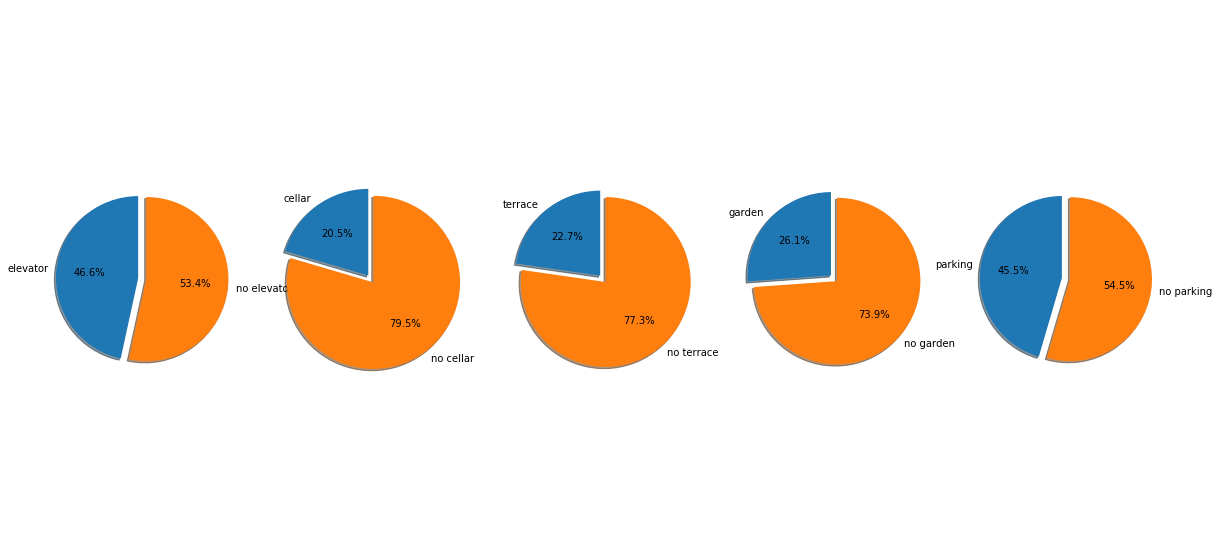

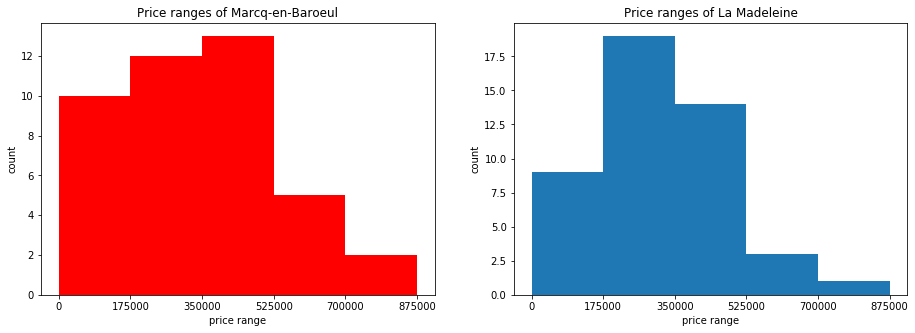

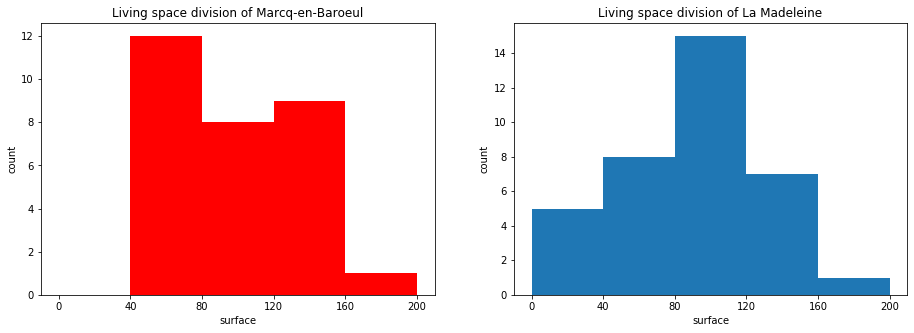

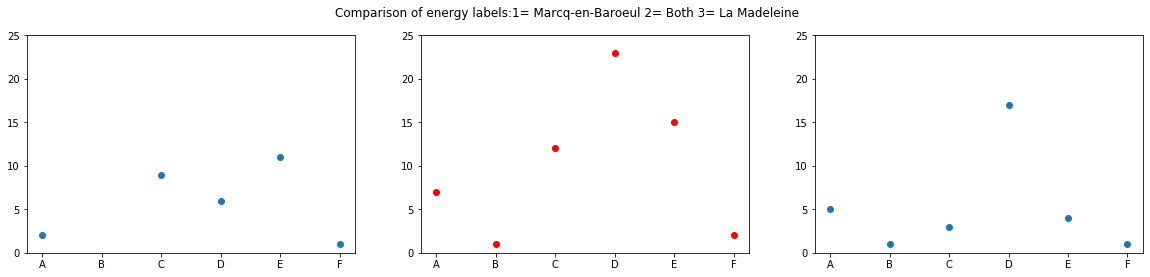

In [423]:
#importing libraries
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

#renaming some of the columns so the graphs look better
dataframe["garden"]=dataframe["dummygarden"]
dataframe["terrace"]=dataframe["dummyterrace"]
dataframe["cellar"]=dataframe["dummycellar"]
dataframe["parking"]=dataframe["dummyparking"]
dataframe["elevator"]=dataframe["dummyelevator"]
counteddataframe = dataframe.apply(pd.value_counts)
listofcols= dataframe.columns

#plotting the dummy variables in piecharts
#defining the variable names
labels = listofcols[-1], 'no '+listofcols[-1]
sizes = [counteddataframe["dummyelevator"][1],(length-counteddataframe["dummyelevator"][1])]
explode = (0.1, 0)  # only "explode" the 2nd slice
labels2 = listofcols[-2], 'no '+listofcols[-2]
sizes2 = [counteddataframe["dummyparking"][1],(length-counteddataframe["dummyparking"][1])]
labels3 = listofcols[-3], 'no '+listofcols[-3]
sizes3 = [counteddataframe["dummycellar"][1],(length-counteddataframe["dummycellar"][1])]
labels4 = listofcols[-4], 'no '+listofcols[-4]
sizes4 = [counteddataframe["dummyterrace"][1],(length-counteddataframe["dummyterrace"][1])]
labels5 = listofcols[-5], 'no '+listofcols[-5]
sizes5 = [counteddataframe["dummygarden"][1],(length-counteddataframe["dummygarden"][1])]

#plotting the piecharts
from matplotlib import pyplot

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5,figsize=(20,10))
#pyplot.subplot(151)

#fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


#pyplot.subplot(153)

#fig3, ax1 = plt.subplots()
ax2.pie(sizes3, explode=explode, labels=labels3, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

#pyplot.subplot(154)

#fig4, ax1 = plt.subplots()
ax3.pie(sizes4, explode=explode, labels=labels4, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax3.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

#pyplot.subplot(155)

#fig5, ax1 = plt.subplots()
ax4.pie(sizes5, explode=explode, labels=labels5, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax4.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

#pyplot.subplot(152)

#fig2, ax1 = plt.subplots()
ax5.pie(sizes2, explode=explode, labels=labels2, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax5.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

#now we are splitting the dataframe up for comparisons of the postalcode 
marcq=dataframe[(dataframe["postalcode"]=="59700")]
madeleine=dataframe[(dataframe["postalcode"]=="59110")]

#plotting them next to eachother for clarity
plt.figure(figsize=(24, 5))


plt.subplot(131)
x = np.random.rand(120)
df = pd.DataFrame({"x":x})

bins= [0,(marcq["price"].max()*0.2),(marcq["price"].max()*0.4),(marcq["price"].max()*0.6),(marcq["price"].max()*0.8),marcq["price"].max()]
plt.hist(marcq["price"], bins=bins,color="red")
plt.xticks(bins)

plt.title('Price ranges of Marcq-en-Baroeul')
plt.xlabel('price range')
plt.ylabel('count')


plt.subplot(132)
x = np.random.rand(120)
df = pd.DataFrame({"x":x})
#using the same bins to compare them more easily
bins= [0,(marcq["price"].max()*0.2),(marcq["price"].max()*0.4),(marcq["price"].max()*0.6),(marcq["price"].max()*0.8),marcq["price"].max()]
plt.hist(madeleine["price"], bins=bins)
plt.xticks(bins)

plt.title('Price ranges of La Madeleine')
plt.xlabel('price range')
plt.ylabel('count')


plt.show()


#plotting them next to eachother for clarity
plt.figure(figsize=(24, 5))


plt.subplot(131)
x = np.random.rand(120)
df = pd.DataFrame({"x":x})
#using the same bins to compare them more easily
bins= [0,(marcq["livingsurface"].max()*0.2),(marcq["livingsurface"].max()*0.4),(marcq["livingsurface"].max()*0.6),(marcq["livingsurface"].max()*0.8),marcq["livingsurface"].max()]
plt.hist(marcq["livingsurface"], bins=bins,color="red")
plt.xticks(bins)

plt.title('Living space division of Marcq-en-Baroeul')
plt.xlabel('surface')
plt.ylabel('count')


plt.subplot(132)
x = np.random.rand(120)
df = pd.DataFrame({"x":x})
#using the same bins to compare them more easily
bins= [0,(marcq["livingsurface"].max()*0.2),(marcq["livingsurface"].max()*0.4),(marcq["livingsurface"].max()*0.6),(marcq["livingsurface"].max()*0.8),marcq["livingsurface"].max()]
plt.hist(madeleine["livingsurface"], bins=bins)
plt.xticks(bins)

plt.title('Living space division of La Madeleine')
plt.xlabel('surface')
plt.ylabel('count')

plt.show()

#now we are going to compare the energy labels for both postalcodes
counthouselabel = counteddataframe.loc[ ["A","B","C","D","E","F","G"] ,["energy1label"] ]

counteddataframeMarcq = marcq.apply(pd.value_counts)
counteddataframeMadeleine = madeleine.apply(pd.value_counts)

counthouselabelMarcq = counteddataframeMarcq.loc[ ["A","B","C","D","E","F","G"] ,["energy1label"] ]
counthouselabelMadeleine = counteddataframeMadeleine.loc[ ["A","B","C","D","E","F","G"] ,["energy1label"] ]

namestotalmarcq = ["A","B","C","D","E","F","G"]
valuestotalmarcq = counthouselabelMarcq["energy1label"]

namestotal = ["A","B","C","D","E","F","G"]
valuestotal = counthouselabel["energy1label"]

namestotalmadeleine = ["A","B","C","D","E","F","G"]
valuestotalmadeleine = counthouselabelMadeleine["energy1label"]

plt.figure(figsize=(20, 4))

plt.subplot(131)
plt.scatter(namestotalmarcq, valuestotalmarcq)
plt.ylim([0,25])
plt.subplot(132)
plt.scatter(namestotal, valuestotal,color="red")
plt.ylim([0,25])
plt.subplot(133)
plt.scatter(namestotalmadeleine, valuestotalmadeleine)
plt.ylim([0,25])
plt.suptitle('Comparison of energy labels:1= Marcq-en-Baroeul 2= Both 3= La Madeleine')
plt.show()